In [1]:
from model_utils import *
from torch import optim
from constants import *
from model import *
from Data_utils import *

device = 'cpu'
# Creating the model from YOLOv3 class 
model = YOLOv3(in_channels=3,num_classes=3).to(device) 
  
# Defining the optimizer 
optimizer = optim.Adam(model.parameters(), lr = leanring_rate) 
  
# Defining the loss function 
loss_fn = YOLOLoss() 
  
# Defining the scaler for mixed precision training 
scaler = torch.cuda.amp.GradScaler() 
  
# Defining the train dataset 
train_dataset = Dataset( 
    csv_file="../../og/train.csv", 
    image_dir="../../og/images/", 
    label_dir="../../og/labels/", 
    grid_sizes=[19,38,76],
    anchors=ANCHORS, 
    transform=train_transform 
) 
  
# Defining the train data loader 
train_loader = torch.utils.data.DataLoader( 
    train_dataset, 
    batch_size = 32, 
    num_workers = 1, 
    shuffle = True, 
    pin_memory = True, 
)

test_dataset = Dataset( 
    csv_file="../../og/train.csv", 
    image_dir="../../og/images/", 
    label_dir="../../og/labels/", 
    grid_sizes=[19,38,76],
    anchors=ANCHORS, 
    transform=test_transform 
)

# Defining the train data loader 
test_loader = torch.utils.data.DataLoader( 
    train_dataset, 
    batch_size = 1, 
    num_workers = 1, 
    shuffle = False, 
    pin_memory = True, 
)
  
# Scaling the anchors 
scaled_anchors = ( 
    torch.tensor(ANCHORS) * 
    torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1,3,2) 
).to(device) 
  
# # Training the model 
# for e in range(1, 2): 
#     print("Epoch:", e) 
#     training_loop(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors) 
#     loss = evaluate(test_loader, model, loss_fn, scaled_anchors) 
#     print("Loss:", loss)
#     # Saving the model 
#     if save_model: 
#         save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")

/Applications/anaconda3/envs/ai/lib/python3.11/site-packages/pydantic/main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
/Applications/anaconda3/envs/ai/lib/python3.11/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


/Applications/anaconda3/envs/ai/lib/python3.11/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


==> Loading checkpoint


/Applications/anaconda3/envs/ai/lib/python3.11/site-packages/pydantic/main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
/Applications/anaconda3/envs/ai/lib/python3.11/site-packages/pydantic/main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized 

1


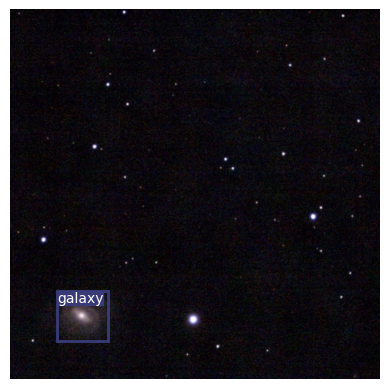

In [2]:
# Taking a sample image and testing the model 
  
# Setting the load_model to True 
load_model = True
  
# Defining the model, optimizer, loss function and scaler 
model = YOLOv3(in_channels=3,num_classes=3).to(device) 
optimizer = optim.Adam(model.parameters(), lr = leanring_rate) 
loss_fn = YOLOLoss() 
scaler = torch.cuda.amp.GradScaler() 
  
# Loading the checkpoint 
if load_model: 
    load_checkpoint(checkpoint_file, model, optimizer, leanring_rate) 
  
# Defining the test dataset and data loader 
test_dataset = Dataset( 
    csv_file="../../og/test.csv", 
    image_dir="../../og/images/", 
    label_dir="../../og/labels/", 
    grid_sizes=[19,38,76],
    anchors=ANCHORS, 
    transform=test_transform 
) 
test_loader = torch.utils.data.DataLoader( 
    test_dataset, 
    batch_size = 1, 
    num_workers = 2, 
    shuffle = True, 
) 

#Getting a sample image from the test data loader 
x, y, labels = next(iter(test_loader)) 
x = x.to(device) 
  
model.eval() 
with torch.no_grad(): 
    # Getting the model predictions 
    output = model(x) 
    # Getting the bounding boxes from the predictions 
    bboxes = [[] for _ in range(x.shape[0])] 
    true_boxes = [[] for _ in range(x.shape[0])]
    anchors = ( 
            torch.tensor(ANCHORS) 
                * torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2) 
            ).to(device) 
  
    # Getting bounding boxes for each scale 
    for i in range(3): 
        batch_size, A, S, _, _ = output[i].shape 
        anchor = anchors[i] 
        boxes_scale_i = convert_cells_to_bboxes( 
                            output[i], anchor, s=S, is_predictions=True
                        )
        for idx, (box) in enumerate(boxes_scale_i): 
            bboxes[idx] += box

print(len(bboxes))
# Plotting the image with bounding boxes for each image in the batch 
for i in range(batch_size): 
    # Applying non-max suppression to remove overlapping bounding boxes 
    nms_boxes = nms(bboxes[i], iou_threshold=0.9, threshold=0.8) 
    # Plotting the image with bounding boxes 
    final_boxes = plot_image(x[i].permute(1,2,0).detach().cpu(), nms_boxes, ["galaxy", "nebula", "star cluster"], 0.5, 1)

In [3]:
# Taking a sample image and testing the model 
  
# Setting the load_model to True 
load_model = True
  
# Defining the model, optimizer, loss function and scaler 
model = YOLOv3(in_channels=3,num_classes=3).to(device) 
optimizer = optim.Adam(model.parameters(), lr = leanring_rate) 
loss_fn = YOLOLoss() 
scaler = torch.cuda.amp.GradScaler() 
  
# Loading the checkpoint 
if load_model: 
    load_checkpoint(checkpoint_file, model, optimizer, leanring_rate) 
  
# Defining the test dataset and data loader 
test_dataset = Dataset( 
    csv_file="../../og/test.csv", 
    image_dir="../../og/images/", 
    label_dir="../../og/labels/", 
    grid_sizes=[19,38,76],
    anchors=ANCHORS, 
    transform=test_transform 
) 
test_loader = torch.utils.data.DataLoader( 
    test_dataset, 
    batch_size = 1, 
    num_workers = 2, 
    shuffle = True, 
) 

y_true, y_pred = test_model(test_loader, model, device)

/Applications/anaconda3/envs/ai/lib/python3.11/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


==> Loading checkpoint


/Applications/anaconda3/envs/ai/lib/python3.11/site-packages/pydantic/main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
/Applications/anaconda3/envs/ai/lib/python3.11/site-packages/pydantic/main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized 

In [6]:
y_true

[1]

In [7]:
y_pred

[1]

/Applications/anaconda3/envs/ai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/envs/ai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/envs/ai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

Classification Report:
               precision    recall  f1-score   support

      galaxy       0.00      0.00      0.00         0
      nebula       1.00      1.00      1.00         1
star_cluster       0.00      0.00      0.00         0
  background       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00         1
   macro avg       0.25      0.25      0.25         1
weighted avg       1.00      1.00      1.00         1

Confusion Matrix:
 [[0 0 0 0]
 [0 1 0 0]
 [0 0 0 0]
 [0 0 0 0]]


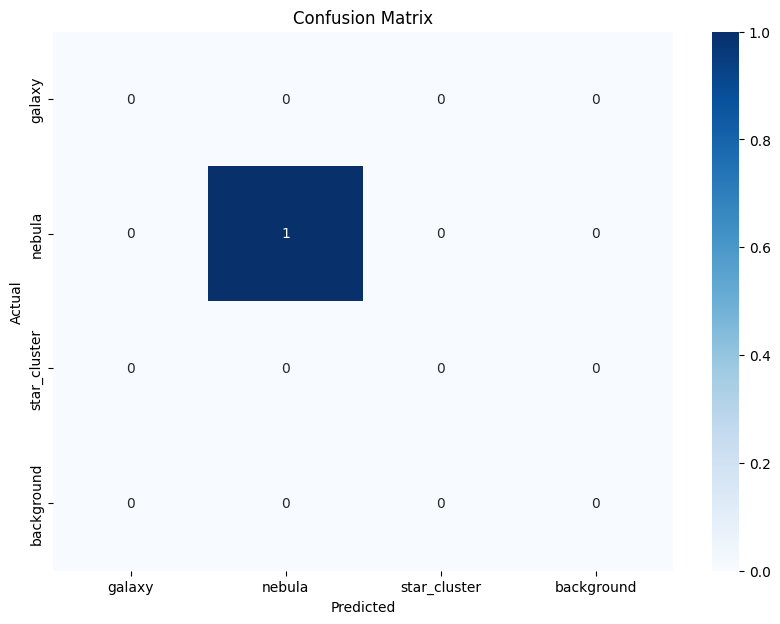

In [8]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


# Define the class names
class_names = ['galaxy', 'nebula', 'star_cluster', 'background']

# Map the class indices to the class names
class_indices = {0: 'galaxy', 1: 'nebula', 2: 'star_cluster', -1: 'background'}

# Adjust the class order to match your specific classes
labels = [0, 1, 2, -1]

# Classification report
report = classification_report(y_true, y_pred, labels=labels, target_names=class_names)
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

print("Confusion Matrix:\n", conf_matrix)

# Optionally, visualize the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for the confusion matrix
import pandas as pd
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
